In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0 # derivate of output of entire expression wrt to this value
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
#       to handle a + 1, basically add an integer
        other = other if isinstance(other, Value) else Value(other)
        
        result = Value(self.data + other.data, (self, other), '+')
        def _backward():
#           += so that a + a is correctly calculated
            self.grad += 1.0 * result.grad
            other.grad += 1.0 * result.grad
#             Author did topological sort instead
#             self._backward()
#             other._backward()
        result._backward = _backward
        return result
    
    def __mul__(self, other):
        #       to handle a * 1, basically add an integer
        other = other if isinstance(other, Value) else Value(other)

        result = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * result.grad
            other.grad += self.data * result.grad
#             Author did topological sort instead
#             self._backward()
#             other._backward()
        result._backward = _backward
        return result
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers!"
        result = Value(self.data**other, (self, ), f'**{other}')
        def _backward():
            self.grad += (other * self.data**(other-1)) * result.grad
        result._backward = _backward
        return result
    
    def __rmul__(self, other):
        return self * other
    
    def __truediv__(self, other):
        return self * other**-1
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def tanh(self):
        _tanh = (math.exp(2*self.data) - 1)/(math.exp(2*self.data) + 1)
        result = Value(_tanh, (self, ), 'tanh')
        def _backward():
            self.grad += (1.0 - _tanh**2) * result.grad
#             Author did topological sort instead
#             self._backward()
        result._backward = _backward
        return result
    
    # e^x --> x.exp()
    def exp(self):
        result = Value(math.exp(self.data), (self, ), 'exp')
        def _backward():
            self.grad += result.data * result.grad
        result._backward = _backward
        return result
    
    def backward(self):
        # topological sort
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
            
# Sidenote: Interestingly just need to define add, mul and pow to do all basic mathematical operations.

In [ ]:
# %pip install graphviz
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad, ), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
            
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

L = d * f

dL/dd = ?

((d+h)*f - d*f)/h == f

dL/dc

first look at dd/dc
d = c + e
=> dd/dc = 1.0

dL/dc = dd/dc * dL/dd

'+' node just route the child gradient

chain rule is the root of the back propagation
with very simple rules

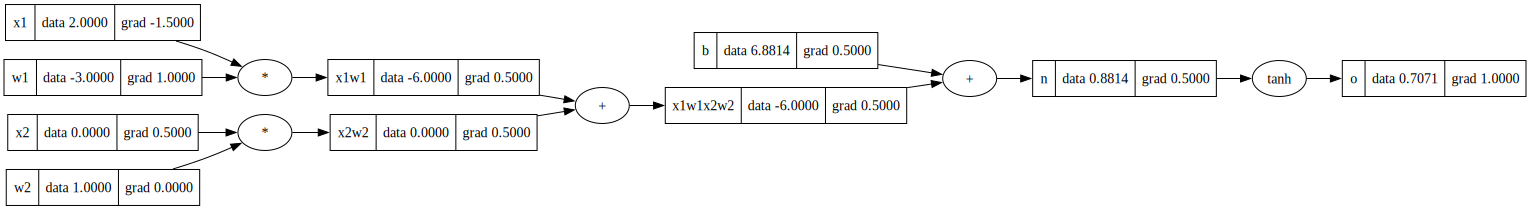

In [24]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

#x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label='x1w1'
x2w2 = x2*w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2;  x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()
draw_dot(o)

In [21]:
# Same operations as above in Pytorch
# %pip install torch
import torch

x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737
